# 3 Model Exploration

## 3.1 Imports and dataset loading

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc, make_scorer, precision_recall_curve
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from interpret.glassbox import ExplainableBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

# Set visualization defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [2]:
output_dir = '../output/'
df = pd.read_csv(output_dir + 'df_cleaned.csv')
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

Dataset loaded: 19701 rows, 41 columns


In [3]:
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19701 entries, 0 to 19700
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Any                        19701 non-null  int64  
 1   zona                       19701 non-null  int64  
 2   nomCom                     19701 non-null  int64  
 3   nomDem                     19701 non-null  int64  
 4   F_MORTS                    19701 non-null  int64  
 5   F_FERITS_GREUS             19701 non-null  int64  
 6   F_FERITS_LLEUS             19701 non-null  int64  
 7   F_VICTIMES                 19701 non-null  int64  
 8   F_UNITATS_IMPLICADES       19701 non-null  int64  
 9   F_VIANANTS_IMPLICADES      19701 non-null  int64  
 10  F_BICICLETES_IMPLICADES    19701 non-null  int64  
 11  F_CICLOMOTORS_IMPLICADES   19701 non-null  int64  
 12  F_MOTOCICLETES_IMPLICADES  19701 non-null  int64  
 13  F_VEH_LLEUGERS_IMPLICADES  19701

In [ ]:
print("\nTarget variable distribution:")
print(df['Mortalitat'].value_counts().sort_index())
print("\nTarget proportions:")
print(df['Mortalitat'].value_counts(normalize=True).sort_index())



Target variable distribution:
Mortalitat
0    16789
1     2912
Name: count, dtype: int64

Target proportions:
Mortalitat
0    0.85219
1    0.14781
Name: proportion, dtype: float64


## 3.2 Data preparation and splits

### Separate features and target

In [3]:
# Remove features that directly encode the target, as seen in EDA
# F_MORTS (deaths), F_FERITS_GREUS (serious injuries), F_FERITS_LLEUS (light injuries), F_VICTIMES (victims)
# These should not be available at prediction time
leakage_features = ['F_MORTS', 'F_FERITS_GREUS', 'F_FERITS_LLEUS', 'F_VICTIMES']

X = df.drop(columns=['Mortalitat'] + leakage_features)
y = df['Mortalitat']

print(f"Removed leakage features: {leakage_features}")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures ({X.shape[1]} columns):")
print(X.columns.tolist())

Removed leakage features: ['F_MORTS', 'F_FERITS_GREUS', 'F_FERITS_LLEUS', 'F_VICTIMES']
Features shape: (19701, 36)
Target shape: (19701,)

Features (36 columns):
['Any', 'zona', 'nomCom', 'nomDem', 'F_UNITATS_IMPLICADES', 'F_VIANANTS_IMPLICADES', 'F_BICICLETES_IMPLICADES', 'F_CICLOMOTORS_IMPLICADES', 'F_MOTOCICLETES_IMPLICADES', 'F_VEH_LLEUGERS_IMPLICADES', 'F_VEH_PESANTS_IMPLICADES', 'C_VELOCITAT_VIA', 'D_BOIRA', 'D_CARACT_ENTORN', 'D_CARRIL_ESPECIAL', 'D_CIRCULACIO_MESURES_ESP', 'D_CLIMATOLOGIA', 'D_FUNC_ESP_VIA', 'D_INTER_SECCIO', 'D_LIMIT_VELOCITAT', 'D_LLUMINOSITAT', 'D_REGULACIO_PRIORITAT', 'D_SENTITS_VIA', 'D_SUBTIPUS_ACCIDENT', 'D_SUBTIPUS_TRAM', 'D_SUBZONA', 'D_SUPERFICIE', 'D_TIPUS_VIA', 'D_TITULARITAT_VIA', 'D_TRACAT_ALTIMETRIC', 'D_VENT', 'hor', 'grupHor', 'tipAcc', 'tipDia', 'Mes']


### Stratified Train/Val/Test split

In [4]:
# First split: 70% train, 30% temp (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Second split: 50% val, 50% test from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Dataset splits:")
print(f"Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Val set:   {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print("\nClass distribution across splits:")
print("\nTrain:")
print(y_train.value_counts(normalize=True).sort_index())
print("\nVal:")
print(y_val.value_counts(normalize=True).sort_index())
print("\nTest:")
print(y_test.value_counts(normalize=True).sort_index())


Dataset splits:
Train set: 13790 samples (70.0%)
Val set:   2955 samples (15.0%)
Test set:  2956 samples (15.0%)

Class distribution across splits:

Train:
Mortalitat
0    0.852212
1    0.147788
Name: proportion, dtype: float64

Val:
Mortalitat
0    0.852115
1    0.147885
Name: proportion, dtype: float64

Test:
Mortalitat
0    0.852165
1    0.147835
Name: proportion, dtype: float64


### Feature scaling

In [5]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to dfs
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled using RobustScaler")


Features scaled using RobustScaler


### Class weights (for imbalanced data)

We use 'balanced' mode from sklearn, which uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. Still, here we show how to compute them manually to see the values.

In [6]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("Class Weights (for handling imbalance):")
print(f"Class 0 (No mortality): {class_weight_dict[0]:.4f}")
print(f"Class 1 (Mortality): {class_weight_dict[1]:.4f}")

Class Weights (for handling imbalance):
Class 0 (No mortality): 0.5867
Class 1 (Mortality): 3.3832


## 3.3 Model exploration

We want to explore different families of models and compare their performance using one same evaluation framework, so that we can select the best model for further hyperparameter tuning and analysis based on the observed trade-offs.

We will be storing an object per each model containing the model itself and its evaluation results, so that we can summarize and compare them later on.

In [7]:
def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, model_name):
    """
    Comprehensive model evaluation on train, val, and test sets using optimized threshold.
    Also measures inference time on validation set
    """
    results = {}
    best_threshold = 0.5  # Default for models without predict_proba
    
    # 1. Optimize Threshold on Validation Set (only if model supports probabilities)
    if hasattr(model, 'predict_proba'):
        # Get probabilities for the positive class
        y_val_proba = model.predict_proba(X_val)[:, 1]
        
        # Calculate precision-recall curve
        precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
        
        # Calculate F1 scores for each threshold
        # Note: precisions and recalls have 1 extra element (for threshold=1)
        with np.errstate(divide='ignore', invalid='ignore'):
            f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
        f1_scores = np.nan_to_num(f1_scores)  # Handle division by zero
        
        # Find the index of the best F1 score
        best_idx = np.argmax(f1_scores)
        
        # Select the corresponding threshold
        if best_idx < len(thresholds):
            best_threshold = thresholds[best_idx]
        else:
            best_threshold = 0.5 # Fallback if something goes wrong
            
        print(f"{model_name} - Optimized Threshold: {best_threshold:.4f}")

    # 2. Evaluate on all sets using the best threshold
    for set_name, X_set, y_set in [
        ('Train', X_train, y_train),
        ('Val', X_val, y_val),
        ('Test', X_test, y_test)
    ]:
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_set)[:, 1]
            # Apply the optimized threshold
            y_pred = (y_proba >= best_threshold).astype(int)
            metrics_auc = roc_auc_score(y_set, y_proba)
        else:
            # Fallback for models like LinearSVC (without probability=True)
            y_pred = model.predict(X_set)
            metrics_auc = None
        
        metrics = {
            'Accuracy': accuracy_score(y_set, y_pred),
            'Precision': precision_score(y_set, y_pred, zero_division=0),
            'Recall': recall_score(y_set, y_pred, zero_division=0),
            'F1': f1_score(y_set, y_pred, zero_division=0),
        }
        
        if metrics_auc is not None:
            metrics['ROC-AUC'] = metrics_auc
        
        results[set_name] = metrics
    
    # 3. Inference Time (standard predict)
    start_time = time.time()
    _ = model.predict(X_val)
    inference_time = (time.time() - start_time) / len(X_val) * 1000  # ms per sample
    results['Inference Time (ms/sample)'] = inference_time
    
    # Store the threshold used
    results['Best Threshold'] = best_threshold
    
    return results

def plot_confusion_matrix(model, X_test, y_test, model_name, threshold=0.5):
    # Generate predictions based on the specific threshold
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)
    else:
        y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
                xticklabels=['No Mortality', 'Mortality'],
                yticklabels=['No Mortality', 'Mortality'])
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title(f'{model_name} - Confusion Matrix (Test Set)')
    plt.tight_layout()
    plt.show()
    
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Mortality', 'Mortality']))

### Logistic regression

Linear model that estimates the probability of an event occurring by fitting a logistic function to the input features. It assumes a linear relationship between the input variables and the odds of the outcome.

Explainability is high (glassbox). We can directly interpret the model's coefficients. A positive coefficient increases the probability of the target class, while a negative one decreases it.


Logistic Regression - Optimized Threshold: 0.5533


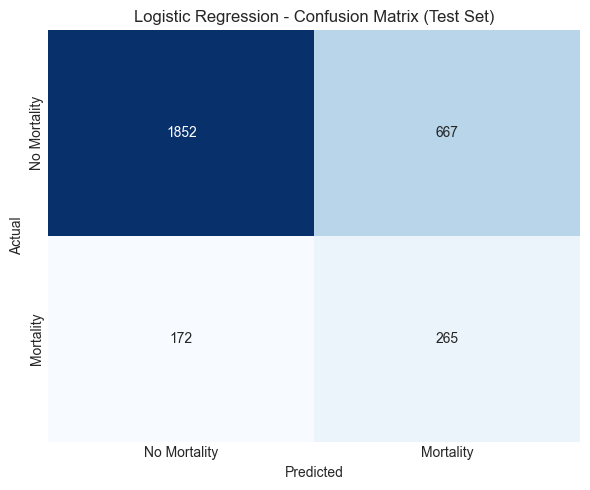


Logistic Regression - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.92      0.74      0.82      2519
   Mortality       0.28      0.61      0.39       437

    accuracy                           0.72      2956
   macro avg       0.60      0.67      0.60      2956
weighted avg       0.82      0.72      0.75      2956



In [ ]:
lr = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

lr_train_start = time.time()
lr.fit(X_train_scaled, y_train)
lr_train_time = time.time() - lr_train_start

lr_results = evaluate_model(lr, X_train_scaled, X_val_scaled, X_test_scaled, 
                            y_train, y_val, y_test, 'Logistic Regression')

lr_info = {
    'model': lr,
    'training_time': lr_train_time,
    'inference_time': lr_results['Inference Time (ms/sample)'],
    'parameters': len(lr.coef_[0]),
    'train_results': lr_results['Train'],
    'test_results': lr_results['Test'],
    'best_threshold': lr_results['Best Threshold']
}

plot_confusion_matrix(lr, X_test_scaled, y_test, 'Logistic Regression', threshold=lr_info['best_threshold'])

### Decision tree

A non-parametric model that splits data into subsets based on feature values, creating a tree-like structure of decision rules to reach a prediction.

Explainability is high (glassbox). We can visualize the tree structure and follow the path from the root to the leaf node to understand the logic behind a specific prediction.



Decision Tree - Optimized Threshold: 1.0000


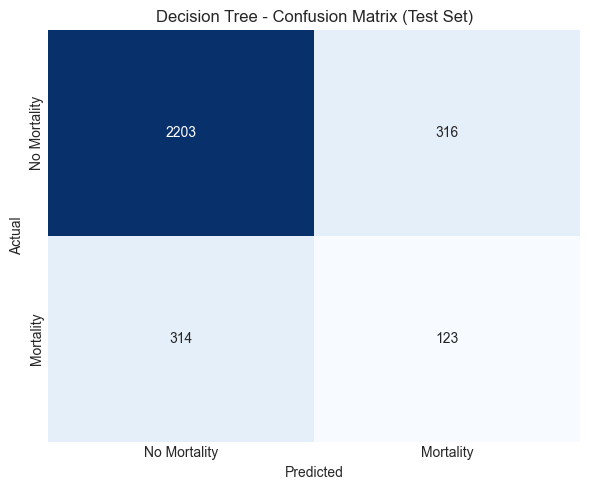


Decision Tree - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.88      0.87      0.87      2519
   Mortality       0.28      0.28      0.28       437

    accuracy                           0.79      2956
   macro avg       0.58      0.58      0.58      2956
weighted avg       0.79      0.79      0.79      2956



In [ ]:
dt = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42,
    max_depth=200,
)

dt_train_start = time.time()
dt.fit(X_train_scaled, y_train)
dt_train_time = time.time() - dt_train_start

dt_results = evaluate_model(dt, X_train_scaled, X_val_scaled, X_test_scaled,
                            y_train, y_val, y_test, 'Decision Tree')

dt_info = {
    'model': dt,
    'training_time': dt_train_time,
    'inference_time': dt_results['Inference Time (ms/sample)'],
    'parameters': dt.tree_.node_count,
    'train_results': dt_results['Train'],
    'test_results': dt_results['Test'],
    'best_threshold': dt_results['Best Threshold']
}

plot_confusion_matrix(dt, X_test_scaled, y_test, 'Decision Tree', threshold=dt_info['best_threshold'])

### Random forest

An ensemble method that constructs a multitude of decision trees during training. It outputs the class that is the mode of the classes of the individual trees, reducing overfitting compared to single decision trees.

Explainability is medium (black-box). While more complex than a single tree, it allows for global interpretation via Feature Importance scores. For local interpretability, use SHAP values to see the contribution of each feature.



Random Forest - Optimized Threshold: 0.5267


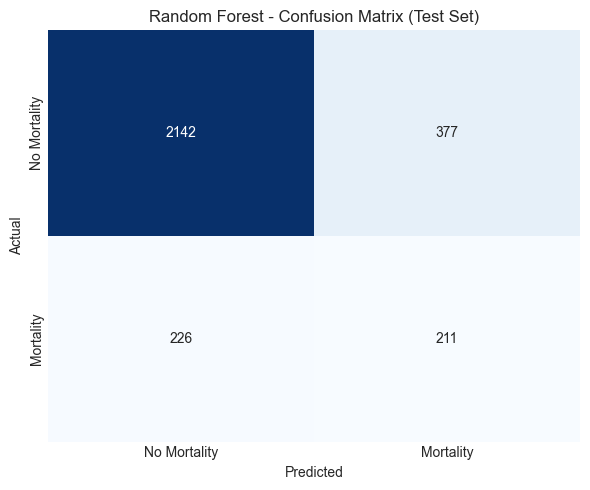


Random Forest - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.90      0.85      0.88      2519
   Mortality       0.36      0.48      0.41       437

    accuracy                           0.80      2956
   macro avg       0.63      0.67      0.64      2956
weighted avg       0.82      0.80      0.81      2956



In [ ]:
rf = RandomForestClassifier(
    n_estimators=8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    max_depth=20,
    min_samples_leaf=10,
)

rf_train_start = time.time()
rf.fit(X_train_scaled, y_train)
rf_train_time = time.time() - rf_train_start

rf_results = evaluate_model(rf, X_train_scaled, X_val_scaled, X_test_scaled,
                            y_train, y_val, y_test, 'Random Forest')

rf_info = {
    'model': rf,
    'training_time': rf_train_time,
    'inference_time': rf_results['Inference Time (ms/sample)'],
    'parameters': sum(t.tree_.node_count for t in rf.estimators_),
    'train_results': rf_results['Train'],
    'test_results': rf_results['Test'],
    'best_threshold': rf_results['Best Threshold']
}

plot_confusion_matrix(rf, X_test_scaled, y_test, 'Random Forest', threshold=rf_info['best_threshold'])

### Gradient boosting

A standard boosting model that builds trees sequentially, where each new tree corrects the errors of the previous ones.

Explainability is medium (black-box): being a boosting model, SHAP is needed for interpretability.


Gradient Boosting - Optimized Threshold: 0.0550


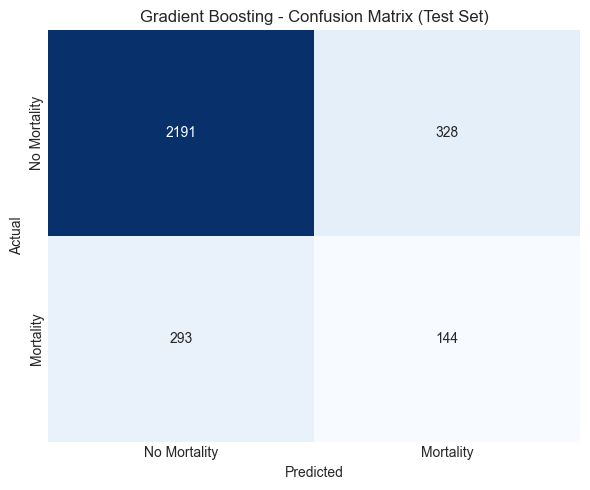


Gradient Boosting - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.88      0.87      0.88      2519
   Mortality       0.31      0.33      0.32       437

    accuracy                           0.79      2956
   macro avg       0.59      0.60      0.60      2956
weighted avg       0.80      0.79      0.79      2956



In [ ]:
gb = GradientBoostingClassifier(
    n_estimators=70,
    max_depth=20,
    learning_rate=0.1,
    random_state=42,
)

gb_train_start = time.time()
gb.fit(X_train_scaled, y_train)
gb_train_time = time.time() - gb_train_start

gb_results = evaluate_model(gb, X_train_scaled, X_val_scaled, X_test_scaled,
                            y_train, y_val, y_test, 'Gradient Boosting')

gb_info = {
    'model': gb,
    'training_time': gb_train_time,
    'inference_time': gb_results['Inference Time (ms/sample)'],
    'parameters': sum(t.tree_.node_count for t in gb.estimators_.ravel()),
    'train_results': gb_results['Train'],
    'test_results': gb_results['Test'],
    'best_threshold': gb_results['Best Threshold']
}

plot_confusion_matrix(gb, X_test_scaled, y_test, 'Gradient Boosting', threshold=gb_info['best_threshold'])

### XGBoost classifier

An optimized version of the gradient boosting algorithm.

Explainability is medium (black-box): being a boosting model, SHAP is needed for interpretability.





XGBoost - Optimized Threshold: 0.5820


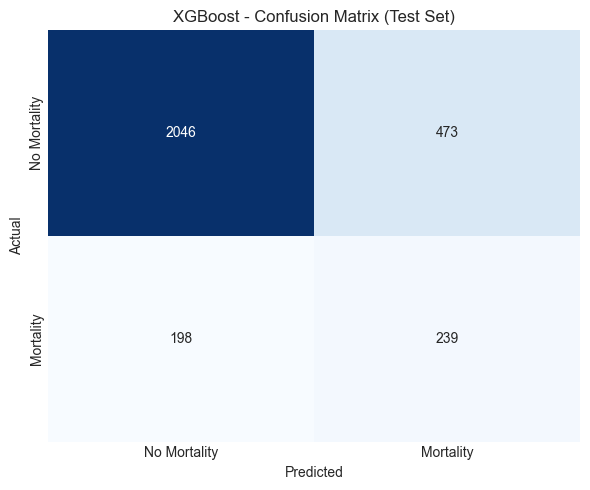


XGBoost - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.91      0.81      0.86      2519
   Mortality       0.34      0.55      0.42       437

    accuracy                           0.77      2956
   macro avg       0.62      0.68      0.64      2956
weighted avg       0.83      0.77      0.79      2956



In [ ]:
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    scale_pos_weight=class_weight_dict[1] / class_weight_dict[0],
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    colsample_bytree=0.6,
)

xgb_train_start = time.time()
xgb.fit(X_train_scaled, y_train)
xgb_train_time = time.time() - xgb_train_start

xgb_results = evaluate_model(xgb, X_train_scaled, X_val_scaled, X_test_scaled,
                             y_train, y_val, y_test, 'XGBoost')

xgb_info = {
    'model': xgb,
    'training_time': xgb_train_time,
    'inference_time': xgb_results['Inference Time (ms/sample)'],
    'parameters': xgb.n_estimators * 5,  # Approximate
    'train_results': xgb_results['Train'],
    'test_results': xgb_results['Test'],
    'best_threshold': xgb_results['Best Threshold']
}

plot_confusion_matrix(xgb, X_test_scaled, y_test, 'XGBoost', threshold=xgb_info['best_threshold'])

### Support Vector Machine

A powerful classifier that finds the hyperplane that best divides a dataset into two classes with the maximum margin. It can handle non-linear boundaries using kernel functions.

Explainability is low (black-box). When using non-linear kernels, the relationship between features and the output is not direct. SHAP (KernelExplainer) is needed for interpretability.

SVM - Optimized Threshold: 0.2148


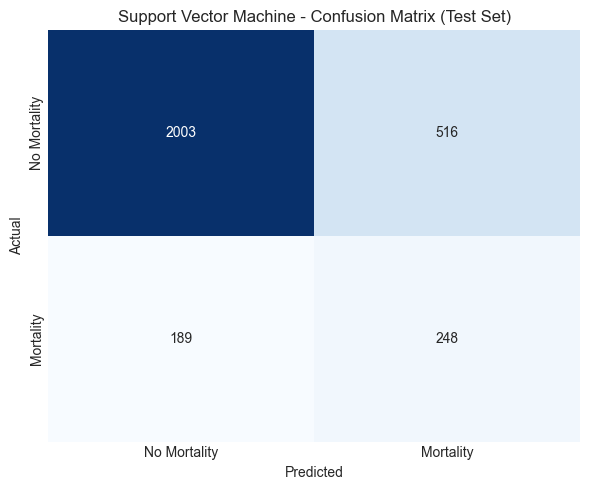


Support Vector Machine - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.91      0.80      0.85      2519
   Mortality       0.32      0.57      0.41       437

    accuracy                           0.76      2956
   macro avg       0.62      0.68      0.63      2956
weighted avg       0.83      0.76      0.79      2956



In [ ]:
svm = SVC(
    kernel='rbf',
    class_weight='balanced',
    random_state=42,
    probability=True
)

svm_train_start = time.time()
svm.fit(X_train_scaled, y_train)
svm_train_time = time.time() - svm_train_start

svm_results = evaluate_model(svm, X_train_scaled, X_val_scaled, X_test_scaled,
                             y_train, y_val, y_test, 'SVM')

svm_info = {
    'model': svm,
    'training_time': svm_train_time,
    'inference_time': svm_results['Inference Time (ms/sample)'],
    'parameters': len(svm.support_vectors_),
    'train_results': svm_results['Train'],
    'test_results': svm_results['Test'],
    'best_threshold': svm_results['Best Threshold']
}

plot_confusion_matrix(svm, X_test_scaled, y_test, 'Support Vector Machine', threshold=svm_info['best_threshold'])

### LightGBM (Light Gradient Boosting Machine)

A gradient boosting framework that uses tree-based learning algorithms. It is designed for distributed and efficient training, often faster than XGBoost and capable of handling large-scale data.

Explainability is medium (black-box): being a boosting model, SHAP is needed for interpretability.

LightGBM - Optimized Threshold: 0.5529


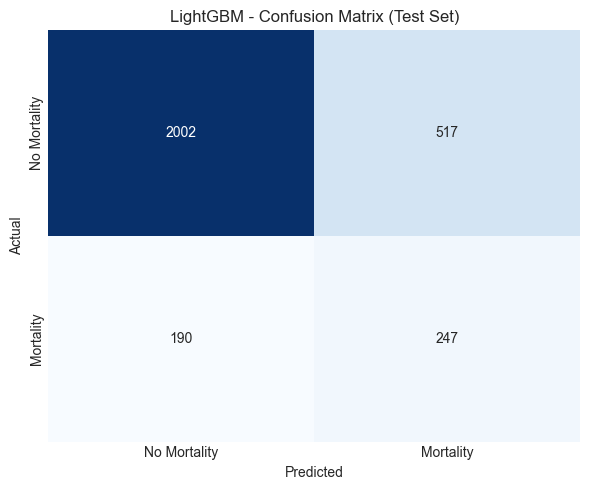


LightGBM - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.91      0.79      0.85      2519
   Mortality       0.32      0.57      0.41       437

    accuracy                           0.76      2956
   macro avg       0.62      0.68      0.63      2956
weighted avg       0.83      0.76      0.79      2956



In [ ]:
lgb = LGBMClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1,
)

lgb_train_start = time.time()
lgb.fit(X_train_scaled, y_train)
lgb_train_time = time.time() - lgb_train_start

lgb_results = evaluate_model(lgb, X_train_scaled, X_val_scaled, X_test_scaled,
                             y_train, y_val, y_test, 'LightGBM')

lgb_info = {
    'model': lgb,
    'training_time': lgb_train_time,
    'inference_time': lgb_results['Inference Time (ms/sample)'],
    'parameters': lgb.n_estimators * 5,  # Approximate
    'train_results': lgb_results['Train'],
    'test_results': lgb_results['Test'],
    'best_threshold': lgb_results['Best Threshold']
}

plot_confusion_matrix(lgb, X_test_scaled, y_test, 'LightGBM', threshold=lgb_info['best_threshold'])


### CatBoost classifier

A gradient boosting method that handles categorical features efficiently. It uses symmetric trees to reduce overfitting and speed up prediction.

Explainability is medium (black-box): being a boosting model, SHAP is needed for interpretability.

CatBoost - Optimized Threshold: 0.3559


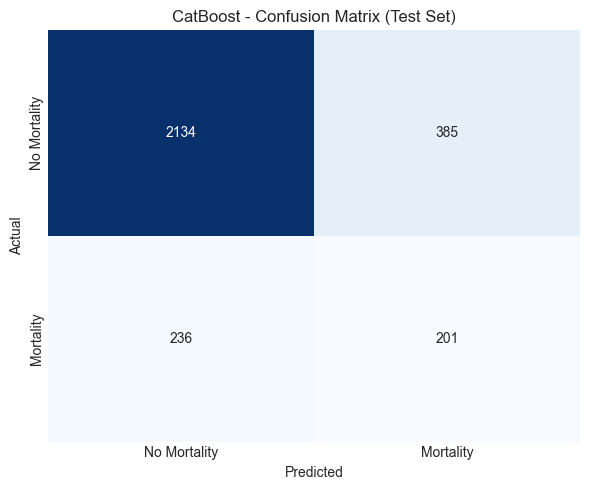


CatBoost - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.90      0.85      0.87      2519
   Mortality       0.34      0.46      0.39       437

    accuracy                           0.79      2956
   macro avg       0.62      0.65      0.63      2956
weighted avg       0.82      0.79      0.80      2956



In [ ]:
cat = CatBoostClassifier(
    iterations=100,
    max_depth=15,
    learning_rate=0.1,
    random_state=42,
    auto_class_weights='Balanced',
    verbose=0,
)

cat_train_start = time.time()
cat.fit(X_train_scaled, y_train)
cat_train_time = time.time() - cat_train_start

cat_results = evaluate_model(cat, X_train_scaled, X_val_scaled, X_test_scaled,
                             y_train, y_val, y_test, 'CatBoost')

cat_info = {
    'model': cat,
    'training_time': cat_train_time,
    'inference_time': cat_results['Inference Time (ms/sample)'],
    'parameters': cat.tree_count_ * 5,  # Approximate
    'train_results': cat_results['Train'],
    'test_results': cat_results['Test'],
    'best_threshold': cat_results['Best Threshold']
}

plot_confusion_matrix(cat, X_test_scaled, y_test, 'CatBoost', threshold=cat_info['best_threshold'])


### Multilayer perceptron

A class of feedforward artificial neural networks. It consists of at least three layers of nodes: an input layer, a hidden layer, and an output layer. It can model complex non-linear relationships.

Explainability is low (black-box). The "deep" internal structure of weights makes it difficult to interpret directly. Explainability relies on methods like SHAP (DeepExplainer).

We have manually tuned hyperparameters to keep a good-performing MLP as the candidate to compare against other model families.

MLP - Optimized Threshold: 0.2085


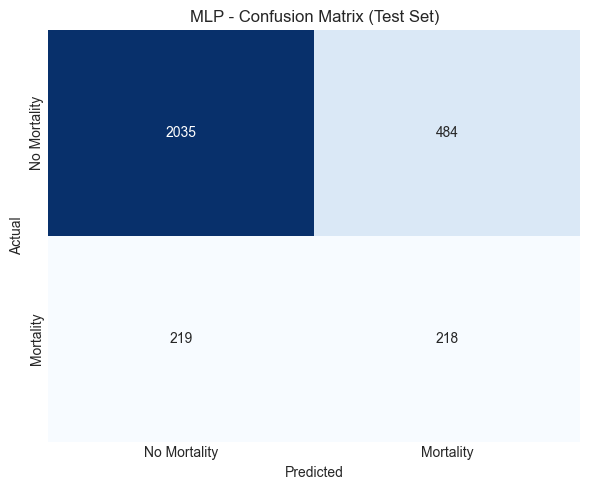


MLP - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.90      0.81      0.85      2519
   Mortality       0.31      0.50      0.38       437

    accuracy                           0.76      2956
   macro avg       0.61      0.65      0.62      2956
weighted avg       0.82      0.76      0.78      2956



In [ ]:
mlp = MLPClassifier(
    hidden_layer_sizes=(30, 30),
    max_iter=5000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
)

mlp_train_start = time.time()
mlp.fit(X_train_scaled, y_train)
mlp_train_time = time.time() - mlp_train_start

mlp_results = evaluate_model(mlp, X_train_scaled, X_val_scaled, X_test_scaled,
                             y_train, y_val, y_test, 'MLP')

mlp_info = {
    'model': mlp,
    'training_time': mlp_train_time,
    'inference_time': mlp_results['Inference Time (ms/sample)'],
    'parameters': sum(w.size for w in mlp.coefs_) + sum(b.size for b in mlp.intercepts_),
    'train_results': mlp_results['Train'],
    'test_results': mlp_results['Test'],
    'best_threshold': mlp_results['Best Threshold']
}

plot_confusion_matrix(mlp, X_test_scaled, y_test, 'MLP', threshold=mlp_info['best_threshold'])


### k-Nearest Neighbors

A simple, instance-based learning algorithm that classifies a new data point based on the majority class of its 'k' nearest neighbors in the feature space.

Explainability is medium. It is interpreted by example: "We predicted Class A because the 5 most similar historical cases were also Class A." However, it doesn't provide a formulaic explanation of which features drove the similarity.

k-NN - Optimized Threshold: 0.2400


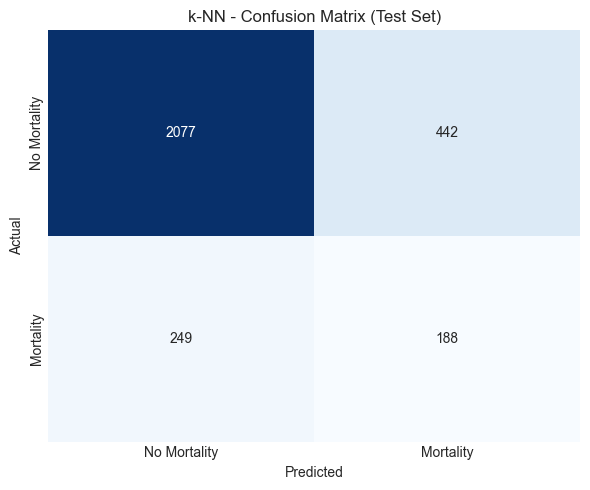


k-NN - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.89      0.82      0.86      2519
   Mortality       0.30      0.43      0.35       437

    accuracy                           0.77      2956
   macro avg       0.60      0.63      0.60      2956
weighted avg       0.81      0.77      0.78      2956



In [ ]:
knn = KNeighborsClassifier(
    n_neighbors=25,
    n_jobs=-1,
    weights='uniform'
)

knn_train_start = time.time()
knn.fit(X_train_scaled, y_train)
knn_train_time = time.time() - knn_train_start

knn_results = evaluate_model(knn, X_train_scaled, X_val_scaled, X_test_scaled,
                             y_train, y_val, y_test, 'k-NN')

knn_info = {
    'model': knn,
    'training_time': knn_train_time,
    'inference_time': knn_results['Inference Time (ms/sample)'],
    'parameters': len(X_train_scaled),  # All training samples are parameters
    'train_results': knn_results['Train'],
    'test_results': knn_results['Test'],
    'best_threshold': knn_results['Best Threshold']
}

plot_confusion_matrix(knn, X_test_scaled, y_test, 'k-NN', threshold=knn_info['best_threshold'])


### Gaussian Naive Bayes

A probabilistic classifier based on applying Bayes' theorem with strong independence assumptions between the features. It assumes features follow a normal distribution.

Explainability is high. It provides probabilities for each class based on individual features. We can easily see which feature pushed the probability towards a specific class, making it very transparent.

Gaussian Naive Bayes - Optimized Threshold: 0.1648


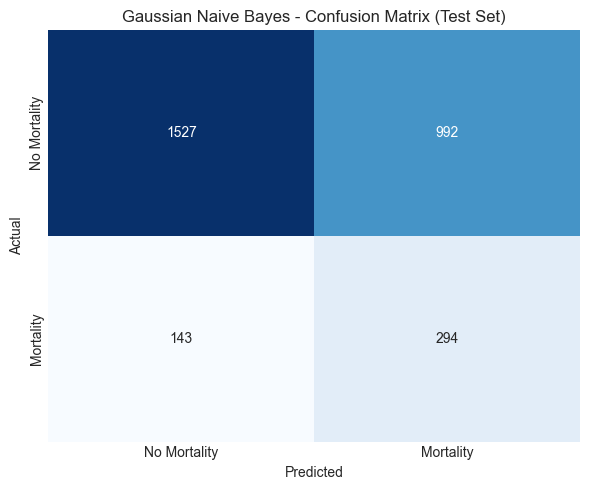


Gaussian Naive Bayes - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.91      0.61      0.73      2519
   Mortality       0.23      0.67      0.34       437

    accuracy                           0.62      2956
   macro avg       0.57      0.64      0.54      2956
weighted avg       0.81      0.62      0.67      2956



In [ ]:
nb = GaussianNB()

nb_train_start = time.time()
nb.fit(X_train_scaled, y_train)
nb_train_time = time.time() - nb_train_start

nb_results = evaluate_model(nb, X_train_scaled, X_val_scaled, X_test_scaled,
                            y_train, y_val, y_test, 'Gaussian Naive Bayes')

nb_info = {
    'model': nb,
    'training_time': nb_train_time,
    'inference_time': nb_results['Inference Time (ms/sample)'],
    'parameters': len(nb.var_) * 2,  # Mean and variance for each feature
    'train_results': nb_results['Train'],
    'test_results': nb_results['Test'],
    'best_threshold': nb_results['Best Threshold']
}

plot_confusion_matrix(nb, X_test_scaled, y_test, 'Gaussian Naive Bayes', threshold=nb_info['best_threshold'])


### Explainable Boosting Machines (EBM)

A model that combines the power of gradient boosting with the interpretability of generalized additive models (GAMs). It learns a graph for each feature's contribution to the prediction.

Explainability is high (glassbox). Designed specifically for interpretability. It provides exact graphs showing how each feature affects the prediction across its entire range, without needing approximation tools like SHAP.

EBM - Optimized Threshold: 0.1959


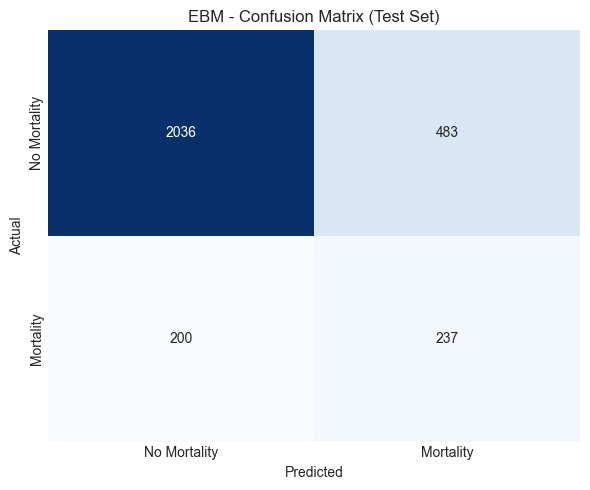


EBM - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.91      0.81      0.86      2519
   Mortality       0.33      0.54      0.41       437

    accuracy                           0.77      2956
   macro avg       0.62      0.68      0.63      2956
weighted avg       0.82      0.77      0.79      2956



In [ ]:
ebm = ExplainableBoostingClassifier(
    max_leaves=10,
    learning_rate=0.01,
    random_state=42,
    n_jobs=-1
)

ebm_train_start = time.time()
ebm.fit(X_train_scaled, y_train)
ebm_train_time = time.time() - ebm_train_start

ebm_results = evaluate_model(ebm, X_train_scaled, X_val_scaled, X_test_scaled,
                             y_train, y_val, y_test, 'EBM')

ebm_info = {
    'model': ebm,
    'training_time': ebm_train_time,
    'inference_time': ebm_results['Inference Time (ms/sample)'],
    'parameters': X_train_scaled.shape[1],  # One function per feature
    'train_results': ebm_results['Train'],
    'test_results': ebm_results['Test'],
    'best_threshold': ebm_results['Best Threshold']
}

plot_confusion_matrix(ebm, X_test_scaled, y_test, 'EBM', threshold=ebm_info['best_threshold'])


### Linear SVM (fast alternative to SVM)

A version of SVM specialized for linear decision boundaries (without kernels). It is faster to train and specifically effective for high-dimensional sparse data.

Explainability is high. Since it uses a linear boundary, we can inspect the coefficients (weights) assigned to each feature to understand their direction and magnitude of influence, similar to Logistic Regression.

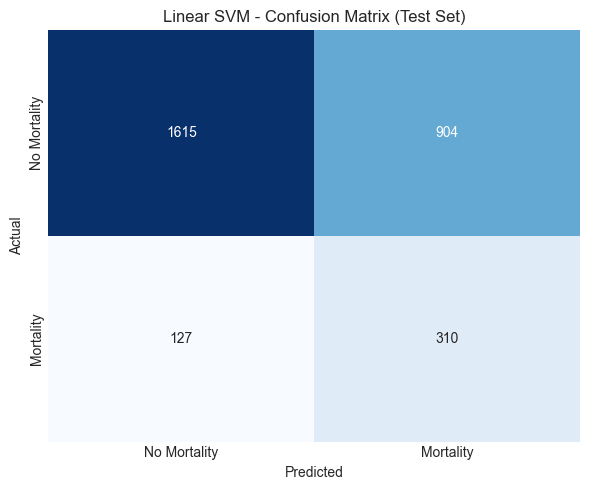


Linear SVM - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.93      0.64      0.76      2519
   Mortality       0.26      0.71      0.38       437

    accuracy                           0.65      2956
   macro avg       0.59      0.68      0.57      2956
weighted avg       0.83      0.65      0.70      2956



In [ ]:
linear_svm = LinearSVC(
    class_weight='balanced',
    random_state=42,
    max_iter=4000
)

lsvm_train_start = time.time()
linear_svm.fit(X_train_scaled, y_train)
lsvm_train_time = time.time() - lsvm_train_start

lsvm_results = evaluate_model(linear_svm, X_train_scaled, X_val_scaled, X_test_scaled,
                              y_train, y_val, y_test, 'Linear SVM')

lsvm_info = {
    'model': linear_svm,
    'training_time': lsvm_train_time,
    'inference_time': lsvm_results['Inference Time (ms/sample)'],
    'parameters': len(linear_svm.coef_[0]),
    'train_results': lsvm_results['Train'],
    'test_results': lsvm_results['Test'],
    'best_threshold': lsvm_results['Best Threshold']
}

plot_confusion_matrix(linear_svm, X_test_scaled, y_test, 'Linear SVM', threshold=lsvm_info['best_threshold'])


## 3.4 Model comparison

### Accuracy and predictive performance trade-offs

In [ ]:
# Create comprehensive comparison dataframe
models_info = {
    'Logistic Regression': lr_info,
    'Decision Tree': dt_info,
    'Random Forest': rf_info,
    'XGBoost': xgb_info,
    'Gradient Boosting': gb_info,
    'SVM (RBF)': svm_info,
    'LightGBM': lgb_info,
    'CatBoost': cat_info,
    'MLP': mlp_info,
    'k-NN': knn_info,
    'Gaussian Naive Bayes': nb_info,
    'EBM': ebm_info,
    'Linear SVM': lsvm_info
}

# Extract test set F1 scores for comparison
f1_scores = {}
for model_name, info in models_info.items():
    f1_scores[model_name] = {
    'Train F1': info['train_results']['F1'],
    'Test F1': info['test_results']['F1']
    }

comparison_df = pd.DataFrame(f1_scores).T
comparison_df = comparison_df.sort_values('Test F1', ascending=False)

print("\n" + "="*80)
print("TRAIN AND TEST SETS PERFORMANCE COMPARISON (F1 Score)")
print("="*60)
print(comparison_df)

# Full comparison table
print("\n" + "="*80)
print("DETAILED TEST SET COMPARISON (sorted by ROC-AUC)")
print("="*60)
detailed_comparison = pd.DataFrame({
    model: info['test_results'] for model, info in models_info.items()
}).T
detailed_comparison = detailed_comparison.sort_values('ROC-AUC', ascending=False)
print(detailed_comparison)


TRAIN AND TEST SETS PERFORMANCE COMPARISON (F1 Score)
                      Train F1   Test F1
XGBoost               0.482871  0.416014
SVM (RBF)             0.499569  0.412989
Random Forest         0.589532  0.411707
LightGBM              0.528719  0.411324
EBM                   0.484079  0.409680
MLP                   0.433412  0.396421
CatBoost              0.924648  0.392962
Logistic Regression   0.369807  0.387144
Linear SVM            0.367384  0.375530
k-NN                  0.431600  0.352390
Gaussian Naive Bayes  0.346567  0.341265
Gradient Boosting     1.000000  0.316832
Decision Tree         1.000000  0.280822

DETAILED TEST SET COMPARISON (sorted by ROC-AUC)
                      Accuracy  Precision    Recall        F1   ROC-AUC
XGBoost               0.773004   0.335674  0.546911  0.416014  0.764198
EBM                   0.768945   0.329167  0.542334  0.409680  0.763311
LightGBM              0.760825   0.323298  0.565217  0.411324  0.761067
Random Forest         0.796008   

### Complexity and performance trade-offs

In [ ]:
complexity_analysis = {
    'Logistic Regression': {
        'Parameters': lr_info['parameters'],
        'Inference Time (ms/sample)': lr_info['inference_time'],
        'Training Time (seconds)': lr_info['training_time']
    },
    'Decision Tree': {
        'Parameters': dt_info['parameters'],
        'Inference Time (ms/sample)': dt_info['inference_time'],
        'Training Time (seconds)': dt_info['training_time']
    },
    'Random Forest': {
        'Parameters': rf_info['parameters'],
        'Inference Time (ms/sample)': rf_info['inference_time'],
        'Training Time (seconds)': rf_info['training_time']
    },
    'XGBoost': {
        'Parameters': xgb_info['parameters'],
        'Inference Time (ms/sample)': xgb_info['inference_time'],
        'Training Time (seconds)': xgb_info['training_time']
    },
    'Gradient Boosting': {
        'Parameters': gb_info['parameters'],
        'Inference Time (ms/sample)': gb_info['inference_time'],
        'Training Time (seconds)': gb_info['training_time']
    },
    'SVM (RBF)': {
        'Parameters': svm_info['parameters'],
        'Inference Time (ms/sample)': svm_info['inference_time'],
        'Training Time (seconds)': svm_info['training_time']
    },
    'LightGBM': {
        'Parameters': lgb_info['parameters'],
        'Inference Time (ms/sample)': lgb_info['inference_time'],
        'Training Time (seconds)': lgb_info['training_time']
    },
    'CatBoost': {
        'Parameters': cat_info['parameters'],
        'Inference Time (ms/sample)': cat_info['inference_time'],
        'Training Time (seconds)': cat_info['training_time']
    },
    'MLP': {
        'Parameters': mlp_info['parameters'],
        'Inference Time (ms/sample)': mlp_info['inference_time'],
        'Training Time (seconds)': mlp_info['training_time']
    },
    'k-NN': {
        'Parameters': knn_info['parameters'],
        'Inference Time (ms/sample)': knn_info['inference_time'],
        'Training Time (seconds)': knn_info['training_time']
    },
    'Gaussian Naive Bayes': {
        'Parameters': nb_info['parameters'],
        'Inference Time (ms/sample)': nb_info['inference_time'],
        'Training Time (seconds)': nb_info['training_time']
    },
    'EBM': {
        'Parameters': ebm_info['parameters'],
        'Inference Time (ms/sample)': ebm_info['inference_time'],
        'Training Time (seconds)': ebm_info['training_time']
    },
    'Linear SVM': {
        'Parameters': lsvm_info['parameters'],
        'Inference Time (ms/sample)': lsvm_info['inference_time'],
        'Training Time (seconds)': lsvm_info['training_time']
    }
}

complexity_df = pd.DataFrame(complexity_analysis).T
print(complexity_df)


                      Parameters  Inference Time (ms/sample)  \
Logistic Regression         36.0                    0.000163   
Decision Tree               27.0                    0.000168   
Random Forest            43660.0                    0.008608   
XGBoost                    500.0                    0.000461   
Gradient Boosting         2852.0                    0.001398   
SVM (RBF)                 9676.0                    0.647782   
LightGBM                   500.0                    0.000991   
CatBoost                   500.0                    0.000478   
MLP                       2071.0                    0.000239   
k-NN                     13790.0                    0.016031   
Gaussian Naive Bayes         4.0                    0.000289   
EBM                         36.0                    0.000812   
Linear SVM                  36.0                    0.000160   

                      Training Time (seconds)  
Logistic Regression                  1.413505  
Decisio

## 3.5 Choosing the most promising models

Here we choose the best models for our case, taking into account accuracy, predictive performance, complexity and timing.

In terms of complexity, we see that Random Forest is the one with the highest number of parameters. However, it doesn't seem to be extremely large. Therefore, we do not discard models based on this condition.

With respect to timing, we discard SVM because of its high inference time. We can similarily discard k-NN. We need fast predictions. The training time does not generate a new discard because all models take an affordable time. This leaves us with 11 models. 

Since we are talking about mortality risk, we are especially interested in having 

We are mainly concerned about two metrics:

1. ROC-AUC: the ability of the model to distinguish between classes.
2. Explainability: the capacity to explain predictions.

Therefore, we now analyze the 11 models ordered by ROC-AUC and recall, adding explainability.

In [ ]:
models_info = {
    'Logistic Regression': lr_info,
    'Decision Tree': dt_info,
    'XGBoost': xgb_info,
    'Gradient Boosting': gb_info,
    'LightGBM': lgb_info,
    'CatBoost': cat_info,
    'MLP': mlp_info,
    'k-NN': knn_info,
    'Gaussian Naive Bayes': nb_info,
    'EBM': ebm_info,
    'Linear SVM': lsvm_info,
    'Random Forest': rf_info,
}

explainability_levels = {
    'Logistic Regression': 'High',
    'Decision Tree': 'High',
    'XGBoost': 'Medium',
    'Gradient Boosting': 'Medium',
    'LightGBM': 'Medium',
    'CatBoost': 'Medium',
    'MLP': 'Low',
    'k-NN': 'Medium',
    'Gaussian Naive Bayes': 'High',
    'EBM': 'High',
    'Linear SVM': 'High',
    'Random Forest': 'Medium',
}

detailed_comparison_with_xai = pd.DataFrame({
    model: info['test_results'] for model, info in models_info.items()
}).T

detailed_comparison_with_xai['Explainability'] = detailed_comparison_with_xai.index.map(explainability_levels)

detailed_comparison_with_xai = detailed_comparison_with_xai.sort_values(by=['ROC-AUC', 'Recall'], ascending=False)

print("\n" + "="*80)
print("DETAILED TEST SET COMPARISON WITH EXPLAINABILITY - ORDERED BY ROC-AUC AND RECALL")
print("="*60)
print(detailed_comparison_with_xai) 



DETAILED TEST SET COMPARISON WITH EXPLAINABILITY - ORDERED BY ROC-AUC AND RECALL
                      Accuracy  Precision    Recall        F1   ROC-AUC  \
XGBoost               0.773004   0.335674  0.546911  0.416014  0.764198   
EBM                   0.768945   0.329167  0.542334  0.409680  0.763311   
LightGBM              0.760825   0.323298  0.565217  0.411324  0.761067   
Random Forest         0.796008   0.358844  0.482838  0.411707  0.747367   
MLP                   0.703315   0.283465  0.659039  0.396421  0.740233   
CatBoost              0.789919   0.343003  0.459954  0.392962  0.723585   
Logistic Regression   0.716171   0.284335  0.606407  0.387144  0.719655   
k-NN                  0.766238   0.298413  0.430206  0.352390  0.699181   
Gaussian Naive Bayes  0.616035   0.228616  0.672769  0.341265  0.686008   
Gradient Boosting     0.789919   0.305085  0.329519  0.316832  0.666366   
Decision Tree         0.786874   0.280182  0.281465  0.280822  0.578009   
Linear SVM        

We will keep only the most promising model families to optimize their hyperparameters, based on the results above. 
We have already discarded SVM and k-NN due to its high inference time. We also now discard MLP given its low explainability and comparable performance to other models.

EBM has an advantage in explainability compared to the other tree-based models, while having comparable performance. However, its training time is significantly higher than the other models (between 10x and 100x more training time), which is a limitation in terms of how many iterations of hyperparameter tuning we can do within a reasonable time frame).

We will be keeping just the following multiple Tree-based models: Random Forest, XGBoost, EBM, LightGBM and CatBoost. We discard Decision Tree and regular Gradient Boosting due to their lower performance compared to the other tree-based models. We also discard the other families (Logistic Regression, Gaussian Naive Bayes, Linear SVM) due to their lower predictive capability compared to the data we have obtained from tree-based models.

## 3.6 Basic hyperparameter tuning

Here we perform an initial, naive basic hyperparameter tuning for our best models using cross-validation, considering all possible thresholds. Once some "good enough" hyperparameters have been identified, the model family is reevaluated in a similar way as before. From this we want to select just one model family for a more extensive hyperparameter optimization in the next notebook, taking into account all the different explored trade-offs.

In [9]:
param_grids = {
    'Random Forest': {
        'n_estimators': [10, 15, 20, 25, 50, 100, 200],
        'max_depth': [5, 10, 15, 20, 40],
        'min_samples_leaf': [2, 5, 10]
    },
    
    'XGBoost': {
        'n_estimators': [10, 15, 20, 25, 50, 100, 200],
        'max_depth': [5, 10, 15, 20, 40],
        'min_child_weight': [2, 5, 10]
    },
    
    'LightGBM': {
        'n_estimators': [100, 200],
        'max_depth': [10, 15, 20],
        'min_child_samples': [2, 5, 10]
    },
    
    'CatBoost': {
        'iterations': [100, 200],
        'max_depth': [10, 15, 20],
        'min_data_in_leaf': [2, 5, 10]
    }
}

In [10]:
# Custom scorer: finds the BEST F1 score across ALL thresholds
def max_f1_scorer(estimator, X, y):
    if hasattr(estimator, "predict_proba"):
        y_scores = estimator.predict_proba(X)[:, 1]
    elif hasattr(estimator, "decision_function"):
        y_scores = estimator.decision_function(X)
    else:
        return f1_score(y, estimator.predict(X), pos_label=1)
    
    precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
    
    # Calculate F1 for all thresholds
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    
    # Return the best F1 score found
    return np.nan_to_num(f1_scores).max()

tuned_results = {}

models_to_tune = {
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
    'XGBoost': XGBClassifier(
        random_state=42, 
        n_jobs=-1, 
        scale_pos_weight=class_weight_dict[1] / class_weight_dict[0],
        verbosity=0
    ),
    'LightGBM': LGBMClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight='balanced',
        verbose=-1
    ),
    'CatBoost': CatBoostClassifier(
        random_state=42,
        auto_class_weights='Balanced',
        verbose=0,
        train_dir=None
    )
}

for name, model in models_to_tune.items():
    print(f"\n{'='*80}")
    print(f"--- Tuning {name} ---")
    print(f"{'='*80}")
    
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring=max_f1_scorer,
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    
    # Fit on training data
    grid.fit(X_train_scaled, y_train)
    
    # Get best model
    best_model = grid.best_estimator_
    
    # Evaluate on all sets with threshold optimization
    eval_results = evaluate_model(best_model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, name)
    
    tuned_results[name] = {
        'best_params': grid.best_params_,
        'CV_Best_F1': grid.best_score_,
        'Test_F1': eval_results['Test']['F1'],
        'Test_ROC_AUC': eval_results['Test'].get('ROC-AUC', None),
        'Best_Threshold': eval_results['Best Threshold'],
        'model': best_model
    }
    
    print(f"\nBest Params: {grid.best_params_}")
    print(f"CV Best F1: {grid.best_score_:.4f}")
    print(f"Test F1: {eval_results['Test']['F1']:.4f}")
    if 'ROC-AUC' in eval_results['Test']:
        print(f"Test ROC-AUC: {eval_results['Test']['ROC-AUC']:.4f}")

# Summary of tuning results
print(f"\n{'='*80}")
print("HYPERPARAMETER TUNING SUMMARY")
print(f"{'='*80}")
tuning_summary = pd.DataFrame({
    model: {
        'Best F1': results['Test_F1'],
        'Best ROC-AUC': results['Test_ROC_AUC']
    }
    for model, results in tuned_results.items()
}).T
tuning_summary = tuning_summary.sort_values('Best F1', ascending=False, na_position='last')
print(tuning_summary)


--- Tuning Random Forest ---
Fitting 3 folds for each of 105 candidates, totalling 315 fits
Random Forest - Optimized Threshold: 0.4267

Best Params: {'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 200}
CV Best F1: 0.4135
Test F1: 0.4127
Test ROC-AUC: 0.7728

--- Tuning XGBoost ---
Fitting 3 folds for each of 105 candidates, totalling 315 fits
Random Forest - Optimized Threshold: 0.4267

Best Params: {'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 200}
CV Best F1: 0.4135
Test F1: 0.4127
Test ROC-AUC: 0.7728

--- Tuning XGBoost ---
Fitting 3 folds for each of 105 candidates, totalling 315 fits
XGBoost - Optimized Threshold: 0.5395

Best Params: {'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 15}
CV Best F1: 0.4083
Test F1: 0.4056
Test ROC-AUC: 0.7554

--- Tuning LightGBM ---
Fitting 3 folds for each of 18 candidates, totalling 54 fits
XGBoost - Optimized Threshold: 0.5395

Best Params: {'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 15}
CV Best F1: 0

From these results we can see that naive hyperparameter tuning hardly improved the manually-tuned hyperparameters we originally had chosen, and does not give us a clear choice onto what model family to select for a full hyperparameter tuning training run. This is somewhat expected, given that despite all models being tree-based, they have different mechanisms and hyperparameters that interact in distinct ways (some models may be more sensitive to certain hyperparameters than others, so using the same grid search strategy for all of them may not be optimal).

Given that we can't do 4 different full hyperparameter tuning runs due to time constraints (potentially hours long, to ensure we find good hyperparameters), we take into account the other characteristics of the models from the previous analysis.

For the remaining models, inference time is comparable between all models, so it is not a deciding factor. Yet training time is very rellevant, and "Random Forest" and "XGBoost" show faster reported training speed. Between these two we see similar results across the different models we have trained (some times one is a bit more accurate, or has a better F1, or better recall,... but overall they are very comparable).

Ultimately, we have selected XGBoost over Random Forest because of its higher sensitivity to parameter tuning and higher theoretical performance ceiling. While Random Forest utilizes a bagging approach that is robust out of the box, we know that it theoretically tends to reach a performance plateau relatively quickly, meaning extensive parameter searching could yield diminishing returns. In contrast, XGBoost’s gradient boosting framework allows for a more aggressive reduction of prediction bias and offers granular control over regularization and learning rates. This makes XGBoost a superior candidate for a dedicated optimization run, as it is mathematically more capable of rewarding our tuning efforts (a dedicated training run) with the marginal gains required to squeeze the maximum possible performance from the data.


## 3.7 One-Hot Encoding vs Label Encoding

To verify whether one-hot encoding categorical variables would improve model generalization compared to the current label encoding approach, we will train XGBoost models with both encoding strategies and compare their performance metrics.


In [ ]:
categorical_cols = ['D_CARACT_ENTORN', 'D_CARRIL_ESPECIAL', 'D_CIRCULACIO_MESURES_ESP',
                    'D_REGULACIO_PRIORITAT', 'D_SENTITS_VIA', 'D_SUBTIPUS_TRAM',
                    'D_TITULARITAT_VIA', 'D_TRACAT_ALTIMETRIC']

# Verify which of these are in our feature set
categorical_cols_in_X = [col for col in categorical_cols if col in X.columns]
print(f"Categorical columns in feature set: {categorical_cols_in_X}")
print(f"Total categorical columns: {len(categorical_cols_in_X)}")

# Create one-hot encoded versions of the data
# We need to apply one-hot encoding on the training set and then transform val/test
X_train_ohe = pd.get_dummies(X_train, columns=categorical_cols_in_X, drop_first=False)
X_val_ohe = pd.get_dummies(X_val, columns=categorical_cols_in_X, drop_first=False)
X_test_ohe = pd.get_dummies(X_test, columns=categorical_cols_in_X, drop_first=False)

# Align columns across train, val, and test sets (in case of missing categories)
# Get all unique columns from all sets
all_ohe_cols = set(X_train_ohe.columns) | set(X_val_ohe.columns) | set(X_test_ohe.columns)

# Add missing columns with 0 values
for col in all_ohe_cols:
    if col not in X_train_ohe.columns:
        X_train_ohe[col] = 0
    if col not in X_val_ohe.columns:
        X_val_ohe[col] = 0
    if col not in X_test_ohe.columns:
        X_test_ohe[col] = 0

# Sort columns to ensure consistent ordering
X_train_ohe = X_train_ohe[sorted(X_train_ohe.columns)]
X_val_ohe = X_val_ohe[sorted(X_val_ohe.columns)]
X_test_ohe = X_test_ohe[sorted(X_test_ohe.columns)]

print(f"\nOne-hot encoded feature shapes:")
print(f"X_train_ohe: {X_train_ohe.shape}")
print(f"X_val_ohe: {X_val_ohe.shape}")
print(f"X_test_ohe: {X_test_ohe.shape}")
print(f"\nOriginal feature shape: {X_train.shape}")

# Now scale the one-hot encoded features
scaler_ohe = RobustScaler()
X_train_ohe_scaled = scaler_ohe.fit_transform(X_train_ohe)
X_val_ohe_scaled = scaler_ohe.transform(X_val_ohe)
X_test_ohe_scaled = scaler_ohe.transform(X_test_ohe)

# Convert back to dataframes
X_train_ohe_scaled = pd.DataFrame(X_train_ohe_scaled, columns=X_train_ohe.columns, index=X_train_ohe.index)
X_val_ohe_scaled = pd.DataFrame(X_val_ohe_scaled, columns=X_val_ohe.columns, index=X_val_ohe.index)
X_test_ohe_scaled = pd.DataFrame(X_test_ohe_scaled, columns=X_test_ohe.columns, index=X_test_ohe.index)

print(f"\nOne-hot encoded and scaled feature shapes:")
print(f"X_train_ohe_scaled: {X_train_ohe_scaled.shape}")
print(f"X_val_ohe_scaled: {X_val_ohe_scaled.shape}")
print(f"X_test_ohe_scaled: {X_test_ohe_scaled.shape}")


Categorical columns in feature set: ['D_CARACT_ENTORN', 'D_CARRIL_ESPECIAL', 'D_CIRCULACIO_MESURES_ESP', 'D_REGULACIO_PRIORITAT', 'D_SENTITS_VIA', 'D_SUBTIPUS_TRAM', 'D_TITULARITAT_VIA', 'D_TRACAT_ALTIMETRIC']
Total categorical columns: 8

One-hot encoded feature shapes:
X_train_ohe: (13790, 81)
X_val_ohe: (2955, 81)
X_test_ohe: (2956, 81)

Original feature shape: (13790, 36)

One-hot encoded and scaled feature shapes:
X_train_ohe_scaled: (13790, 81)
X_val_ohe_scaled: (2955, 81)
X_test_ohe_scaled: (2956, 81)



### Training XGBoost with Label Encoding (current approach)

We'll use the best XGBoost hyperparameters from our basic initial tuning efforts.

In [16]:
print("="*80)
print("TRAINING: XGBoost with Label Encoding (current approach)")
print("="*80)

# Use the best hyperparameters we found earlier (from tuned_results)
xgb_best_params = tuned_results['XGBoost']['best_params'] if 'XGBoost' in tuned_results else {
    'n_estimators': 200,
    'max_depth': 7,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

print(f"\nUsing XGBoost hyperparameters:")
print(xgb_best_params)

# Train on label-encoded data
start_time = time.time()
xgb_label_encoded = XGBClassifier(
    **xgb_best_params,
    random_state=42,
    class_weight='balanced',
    eval_metric='logloss',
    verbose=0
)

xgb_label_encoded.fit(X_train_scaled, y_train)
label_encoding_train_time = time.time() - start_time

print(f"\nTraining time: {label_encoding_train_time:.2f} seconds")

# Evaluate
label_encoded_results = evaluate_model(
    xgb_label_encoded, X_train_scaled, X_val_scaled, X_test_scaled,
    y_train, y_val, y_test, "XGBoost (Label Encoded)"
)

print("\n" + "="*80)
print("RESULTS: XGBoost with Label Encoding")
print("="*80)
for set_name in ['Train', 'Val', 'Test']:
    print(f"\n{set_name} Set:")
    for metric_name, metric_value in label_encoded_results[set_name].items():
        print(f"  {metric_name}: {metric_value:.4f}")


TRAINING: XGBoost with Label Encoding (current approach)

Using XGBoost hyperparameters:
{'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 15}

Training time: 0.04 seconds
XGBoost (Label Encoded) - Optimized Threshold: 0.1804

RESULTS: XGBoost with Label Encoding

Train Set:
  Accuracy: 0.7595
  Precision: 0.3436
  Recall: 0.6894
  F1: 0.4586
  ROC-AUC: 0.8026

Val Set:
  Accuracy: 0.7459
  Precision: 0.3162
  Recall: 0.6178
  F1: 0.4183
  ROC-AUC: 0.7523

Test Set:
  Accuracy: 0.7361
  Precision: 0.3026
  Recall: 0.6018
  F1: 0.4028
  ROC-AUC: 0.7612



### Training XGBoost with One-Hot Encoding

We'll train the same model with the same hyperparameters but on one-hot encoded features to compare generalization.

In [ ]:
# Train XGBoost with one-hot encoding
print("\n" + "="*80)
print("TRAINING: XGBoost with One-Hot Encoding")
print("="*80)

print(f"\nUsing the same XGBoost hyperparameters as label-encoded version")

# Train on one-hot encoded data
start_time = time.time()
xgb_one_hot_encoded = XGBClassifier(
    **xgb_best_params,
    random_state=42,
    class_weight='balanced',
    eval_metric='logloss',
    verbose=0
)

xgb_one_hot_encoded.fit(X_train_ohe_scaled, y_train)
one_hot_encoding_train_time = time.time() - start_time

print(f"\nTraining time: {one_hot_encoding_train_time:.2f} seconds")

# Evaluate
one_hot_encoded_results = evaluate_model(
    xgb_one_hot_encoded, X_train_ohe_scaled, X_val_ohe_scaled, X_test_ohe_scaled,
    y_train, y_val, y_test, "XGBoost (One-Hot Encoded)"
)

print("\n" + "="*80)
print("RESULTS: XGBoost with One-Hot Encoding")
print("="*80)
for set_name in ['Train', 'Val', 'Test']:
    print(f"\n{set_name} Set:")
    for metric_name, metric_value in one_hot_encoded_results[set_name].items():
        print(f"  {metric_name}: {metric_value:.4f}")



TRAINING: XGBoost with One-Hot Encoding

Using the same XGBoost hyperparameters as label-encoded version

Training time: 0.05 seconds
XGBoost (One-Hot Encoded) - Optimized Threshold: 0.2399

RESULTS: XGBoost with One-Hot Encoding

Train Set:
  Accuracy: 0.8222
  Precision: 0.4196
  Recall: 0.5299
  F1: 0.4683
  ROC-AUC: 0.8022

Val Set:
  Accuracy: 0.8051
  Precision: 0.3720
  Recall: 0.4622
  F1: 0.4122
  ROC-AUC: 0.7574

Test Set:
  Accuracy: 0.8085
  Precision: 0.3748
  Recall: 0.4416
  F1: 0.4055
  ROC-AUC: 0.7666


In [18]:

# Create comprehensive comparison dataframe
print("\n" + "="*80)
print("COMPARATIVE ANALYSIS: Generalization Metrics")
print("="*80)

# Extract key metrics for comparison
comparison_data = {
    'XGBoost (Label Encoded)': {
        'Train F1': label_encoded_results['Train']['F1'],
        'Val F1': label_encoded_results['Val']['F1'],
        'Test F1': label_encoded_results['Test']['F1'],
        'Train ROC-AUC': label_encoded_results['Train'].get('ROC-AUC'),
        'Val ROC-AUC': label_encoded_results['Val'].get('ROC-AUC'),
        'Test ROC-AUC': label_encoded_results['Test'].get('ROC-AUC'),
        'Train Recall': label_encoded_results['Train']['Recall'],
        'Test Recall': label_encoded_results['Test']['Recall'],
        'Train Precision': label_encoded_results['Train']['Precision'],
        'Test Precision': label_encoded_results['Test']['Precision'],
        'Training Time (s)': label_encoding_train_time,
        'Inference Time (ms/sample)': label_encoded_results['Inference Time (ms/sample)'],
        'Best Threshold': label_encoded_results['Best Threshold'],
        'Feature Dimensions': X_train_scaled.shape[1],
    },
    'XGBoost (One-Hot Encoded)': {
        'Train F1': one_hot_encoded_results['Train']['F1'],
        'Val F1': one_hot_encoded_results['Val']['F1'],
        'Test F1': one_hot_encoded_results['Test']['F1'],
        'Train ROC-AUC': one_hot_encoded_results['Train'].get('ROC-AUC'),
        'Val ROC-AUC': one_hot_encoded_results['Val'].get('ROC-AUC'),
        'Test ROC-AUC': one_hot_encoded_results['Test'].get('ROC-AUC'),
        'Train Recall': one_hot_encoded_results['Train']['Recall'],
        'Test Recall': one_hot_encoded_results['Test']['Recall'],
        'Train Precision': one_hot_encoded_results['Train']['Precision'],
        'Test Precision': one_hot_encoded_results['Test']['Precision'],
        'Training Time (s)': one_hot_encoding_train_time,
        'Inference Time (ms/sample)': one_hot_encoded_results['Inference Time (ms/sample)'],
        'Best Threshold': one_hot_encoded_results['Best Threshold'],
        'Feature Dimensions': X_train_ohe_scaled.shape[1],
    }
}

comparison_df = pd.DataFrame(comparison_data).T

print("\nFull Comparison Table:")
print(comparison_df.to_string())

test_f1_label = label_encoded_results['Test']['F1']
test_f1_ohe = one_hot_encoded_results['Test']['F1']
f1_improvement = ((test_f1_ohe - test_f1_label) / test_f1_label) * 100

test_auc_label = label_encoded_results['Test'].get('ROC-AUC', 0)
test_auc_ohe = one_hot_encoded_results['Test'].get('ROC-AUC', 0)
auc_improvement = ((test_auc_ohe - test_auc_label) / test_auc_label * 100) if test_auc_label > 0 else 0

gen_gap_label = generalization_analysis['Label Encoded']['F1 Gap']
gen_gap_ohe = generalization_analysis['One-Hot Encoded']['F1 Gap']
gap_reduction = ((gen_gap_label - gen_gap_ohe) / gen_gap_label * 100) if gen_gap_label > 0 else 0

print(f"\n1. Test F1 Score:")
print(f"   - Label Encoded: {test_f1_label:.4f}")
print(f"   - One-Hot Encoded: {test_f1_ohe:.4f}")
print(f"   - Change: {f1_improvement:+.2f}%")

print(f"\n2. Test ROC-AUC Score:")
print(f"   - Label Encoded: {test_auc_label:.4f}")
print(f"   - One-Hot Encoded: {test_auc_ohe:.4f}")
print(f"   - Change: {auc_improvement:+.2f}%")

print(f"\n3. Feature dimensionality:")
print(f"   - Label Encoded: {X_train_scaled.shape[1]} features")
print(f"   - One-Hot Encoded: {X_train_ohe_scaled.shape[1]} features")
print(f"   - Increase: {X_train_ohe_scaled.shape[1] - X_train_scaled.shape[1]} features ({((X_train_ohe_scaled.shape[1] - X_train_scaled.shape[1]) / X_train_scaled.shape[1] * 100):.1f}%)")

print(f"\n4. Computational efficiency:")
print(f"   - Label Encoded Training Time: {label_encoding_train_time:.2f}s")
print(f"   - One-Hot Encoded Training Time: {one_hot_encoding_train_time:.2f}s")
print(f"   - Time Increase: {((one_hot_encoding_train_time - label_encoding_train_time) / label_encoding_train_time * 100):+.1f}%")



if f1_improvement > 1:
    encoding_recommendation = "One-Hot Encoding appears to provide BETTER generalization"
    reason = f"Test F1 improved by {f1_improvement:.2f}%"
elif f1_improvement < -1:
    encoding_recommendation = "Label Encoding provides BETTER generalization"
    reason = f"Test F1 decreased by {abs(f1_improvement):.2f}% with One-Hot Encoding"
else:
    encoding_recommendation = "Both approaches show SIMILAR generalization"
    reason = f"Test F1 difference is negligible ({f1_improvement:+.2f}%)"

print(f"\n{encoding_recommendation}")
print(f"Reason: {reason}")
print(f"\nComputational trade-off: Training time increases by {((one_hot_encoding_train_time - label_encoding_train_time) / label_encoding_train_time * 100):.1f}% with One-Hot Encoding")



COMPARATIVE ANALYSIS: Generalization Metrics

Full Comparison Table:
                           Train F1    Val F1   Test F1  Train ROC-AUC  Val ROC-AUC  Test ROC-AUC  Train Recall  Test Recall  Train Precision  Test Precision  Training Time (s)  Inference Time (ms/sample)  Best Threshold  Feature Dimensions
XGBoost (Label Encoded)    0.458626  0.418280  0.402757       0.802632     0.752338      0.761163      0.689401     0.601831         0.343605        0.302647           0.040851                    0.000417        0.180431                36.0
XGBoost (One-Hot Encoded)  0.468343  0.412245  0.405462       0.802184     0.757388      0.766604      0.529931     0.441648         0.419580        0.374757           0.046694                    0.000544        0.239948                81.0

1. Test F1 Score:
   - Label Encoded: 0.4028
   - One-Hot Encoded: 0.4055
   - Change: +0.67%

2. Test ROC-AUC Score:
   - Label Encoded: 0.7612
   - One-Hot Encoded: 0.7666
   - Change: +0.71%

3. Feature 

We can see how it is not significantly better, yet it increases feature dimensionality a lot and has a 10% higher training time. Therefore, we will keep using Label Encoding for categorical features in our final model.